In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense

from tsextract.feature_extraction.extract import build_features 

import matplotlib as plt

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
df_init = pd.read_csv('4362249.csv')
df_init.head()

,DateTime,Vehicles
0,01 00:00:00,559
1,01 01:00:00,585
2,01 02:00:00,425
3,01 03:00:00,284
4,01 04:00:00,389


In [3]:
features_request = {
    "window":[24]
}

TRAIN_RATIO = 0.8

X = build_features(df_init["Vehicles"], features_request, target_lag = 1, include_tzero=False)

window_size = features_request['window'][0]

y = df_init[['Vehicles']][window_size:-1]

X_train = X[:int(X.shape[0] * TRAIN_RATIO)]
y_train = y[:int(y.shape[0] * TRAIN_RATIO)]

X_test = X[int(X.shape[0] * TRAIN_RATIO):]
y_test = y[int(y.shape[0] * TRAIN_RATIO):]

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = pd.DataFrame(y_scaler.fit_transform(y_train), index = y_train.index)

X_test_scaled = X_scaler.fit_transform(X_test)
y_test_scaled = pd.DataFrame(y_scaler.fit_transform(y_test), index = y_test.index)

0.8420546693669617
113.90880451324979
93.45222352391524


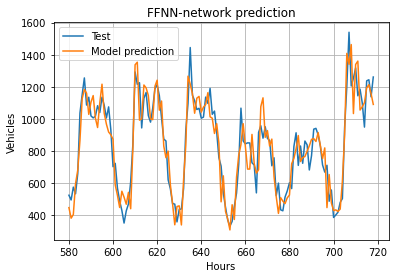

In [4]:
model = Sequential()
model.add(Dense(100, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

model.fit(X_train_scaled, y_train_scaled, epochs = 100, batch_size = 200, verbose = 0)

y_test_predict = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), index = y_test_scaled.index)

ax = y_test_predict.plot()
y_test.plot(ax = ax)
ax.legend(['Test', 'Model prediction'])
ax.set_xlabel('Hours')
ax.set_ylabel('Vehicles')
ax.set_title('FFNN-network prediction')
ax.grid('on')
print(r2_score(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict, squared=False))
print(mean_absolute_error(y_test, y_test_predict))

In [5]:
def rolling_prediction_keras(model, df_init, timesteps):
    df = df_init.copy()
    df_windowed = df.copy()
    for i in range(0, timesteps):
        df_windowed = df[-2*window_size:]
        new = pd.DataFrame({"DateTime" : df_windowed.iloc[-1]['DateTime'] + pd.to_timedelta(1, unit = 'h'),
                            "Vehicles" : df['Vehicles'].iloc[-1]}, index = [df.shape[0]])
        df_windowed = df_windowed.append(new)
        features = build_features(df_windowed["Vehicles"], features_request, target_lag = 1, include_tzero=False)
        features_scaled = pd.DataFrame(X_scaler.fit_transform(features), index=features.index, columns=features.columns)
        predict_value = y_scaler.inverse_transform(model.predict(features_scaled.iloc[[-1]]))
        y_predict = pd.DataFrame({"DateTime" : df.iloc[-1]['DateTime'] + pd.to_timedelta(1, unit = 'h'),
                                  "Vehicles" : predict_value[0]}, index = [df.shape[0]])
        df = df.append(y_predict)
    return df

In [6]:
timesteps = 32
df = rolling_prediction_keras(model, df_init, timesteps)

In [7]:
df['Vehicles']

0       559.000000
1       585.000000
2       425.000000
3       284.000000
4       389.000000
          ...     
747    1392.315552
748    1492.250122
749    1452.242920
750    1397.646484
751    1350.247314
Name: Vehicles, Length: 752, dtype: float64

<AxesSubplot:>

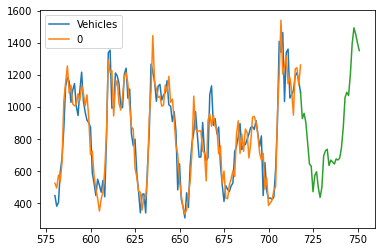

In [8]:
ax = y_test.plot()
y_test_predict.plot(ax = ax)
df['Vehicles'][-timesteps - 2:].plot(ax = ax)